# Olivine Diffusion

Olivine is one of the most important mineral composition the upper mantle and controlling its rheology as well as seismic and eletric properties. Several studies pointed the role of water on the properties of olivine, and, hence, on those of the mantle. Despite such importance, it turns out that we do not have a consensus on the way water is stored and diffuse in olivine, as this is a very complex process.

Water diffusion in olivine seems to be linked to its diffusion in various point defects, namely Si and Mg vacancies as well as in Mg vacancies in association with trivalent cations like Al$^{3+}$ or Fe$^{3+}$, or forming a Ti-clinohumite like point defect.

In this notebook, we will see if we can see such association in a forsterite crystal that has been hydroxylated during an experiment in a piston-cylinder. The experiment lasted 48 hours at 1400 °C and 1.5 GPa. How water diffuses in those conditions in the Fo crystal ?

**This is a real worl problem, published in**

*C. Le Losq, M. C. Jollands, P. M. E. Tollan, R. Hawkins, H. St. C. O’Neill, Point defect populations of forsterite revealed by two-stage metastable hydroxylation experiments. Contrib Mineral Petrol. 174, 53 (2019).*


# Diffusion in olivine

We can study this question as an speudo-equilibrium is rapidly established at the boundary of our olivine crystal, imposing a concentration $c_0$ at the boundary (faces of our crystal, a cube of 1x1x1 mm)

To study the diffusive process, we can use the Fick equations. In particular, the second law of Fick allows describing the variation of the concentration of a substance in a media given time. In one dimension, we have:

$ \frac{\partial c}{\partial t} $ = D $ \frac{\partial^2 c }{\partial x^2} $ .   (eq. 1)

Assuming a constant concentration $c_0$ at $x$ = 0, a simple solution is given by : 

$ c(x,t) = c_0 \text{erfc}({\frac{x}{2\sqrt{Dt}}})$ . (eq. 2)

Represent below the profil of concentration at t = 0 h, t = 12 h, t = 24 h and t = 48 h.

*Tips: (1) erfc function is provided by scipy.special; (2) t=0 does not work, but you can use t=0.000001 as an approximation.*

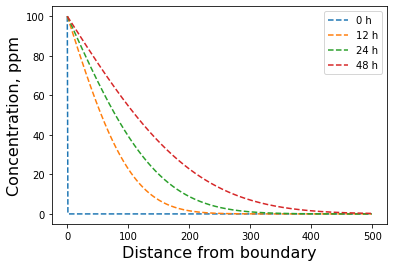

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from scipy.special import erfc

def diff(x,t,D,c0):
    """1D solution to Fick second law
    
    Parameters
    ----------
    x : distance in microns
    
    t : time in h
    
    D : diffusion coefficient in log10 m2 s-1
    
    c0 : concentration at the border in ppm
    
    Returns
    -------
    c : concentration at distance x
    """
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t*3600)))

x = np.arange(0,500,1.0) # Notre profil de la bordure au centre

x0 = 100.0 # ppm, la concentration en eau à la bordure

D = -13.1 # m2 s-1, le coefficient de diffusion à la température de travail, 1400 °C

plt.plot(x, diff(x,0.00001,D,100.0),"--",label="0 h")
plt.plot(x, diff(x,12,D,100.0),"--",label="12 h")
plt.plot(x, diff(x,24,D,100.0),"--",label="24 h")
plt.plot(x, diff(x,48,D,100.0),"--",label="48 h")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()

# Application to real-world data

You will find two files with concentrations in Al, Fe, Sc... measured by LA-ICP-MS after one experiments. Hit: conditions are in the filename...

Using the equation presented above, try to : 
- fit those data and determine the diffusion coefficients of those elements; 
- provide sensible errors bars for the parameters, and propagate them on the fit solution. 
- Re-do the above graph for all elements with errors bars

Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')
Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')


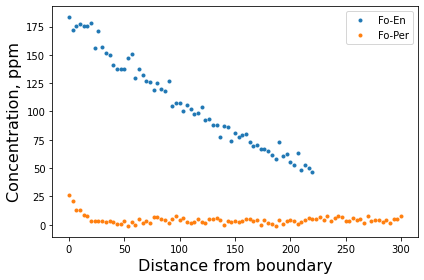

In [2]:
data_1400C_192h_FoEn = pd.read_csv("16C_ICP1_1400C_axisC_192h_FoEn.csv")
print(data_1400C_192h_FoEn.columns)
data_1400C_192h_FoPer = pd.read_csv("16B_ICP2_1400C_axisC_192h_FoPer.csv")
print(data_1400C_192h_FoPer.columns)

plt.plot(data_1400C_192h_FoEn.Distance,data_1400C_192h_FoEn.Fe_ppm_m57,".",label="Fo-En")
plt.plot(data_1400C_192h_FoPer.Distance,data_1400C_192h_FoPer.Fe_ppm_m57,".",label="Fo-Per")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

t_exp = 192.0*3600
x_obs_1 = data_1400C_192h_FoEn.Distance
y_obs_1 = data_1400C_192h_FoEn.Fe_ppm_m57
ese_obs_1 = 7.0*np.ones(len(x_obs_1))

# Problem resolution